In [8]:
from dotenv import load_dotenv
load_dotenv()

True

In [9]:
import json
import pandas as pd
from pathlib import Path
from copy import deepcopy
from functools import partial

from bellek.musique.qa import answer_question_standard, answer_question_cot, answer_question_cot_fs, answer_question_cte
from bellek.utils import set_seed, jprint
from bellek.musique.singlehop import benchmark

set_seed(89)

In [10]:
from tqdm.auto import tqdm
tqdm.pandas()

In [11]:
pd.options.display.float_format = '{:,.3f}'.format

In [12]:
def perfect_retrieval_func(docs, query):
    return [doc for doc in docs if doc['is_supporting']]

In [13]:
N_RUNS = 1

In [14]:
from bellek.musique.constants import ABLATION_RECORD_IDS

df = pd.read_json('../../data/generated/musique-common/base-dataset-validation.jsonl', orient='records', lines=True)
df = df.set_index('id', drop=False).loc[ABLATION_RECORD_IDS].copy().reset_index(drop=True)
# df = df.sample(10)

print(df.shape)
df.head()

(100, 8)


,id,paragraphs,question,question_decomposition,answer,answer_aliases,answerable,answers
0,2hop__575188_342798,"[{'idx': 0, 'title': 'Liliana Mumy', 'paragrap...",Who is the child of Mahmoud Mirza's father?,"[{'id': 575188, 'question': 'Mahmoud Mirza >> ...",Ahmad Shah Qajar,[Ahmad Shah Qajar],True,[Ahmad Shah Qajar]
1,2hop__731584_700117,"[{'idx': 0, 'title': 'KAPE', 'paragraph_text':...",In which county is the city to which KKVU is l...,"[{'id': 731584, 'question': 'KKVU >> licensed ...",Berrien County,[Berrien County],True,[Berrien County]
2,2hop__690412_526810,"[{'idx': 0, 'title': 'Cabramatta Creek', 'para...",For what river does the river on which Pa Sak ...,"[{'id': 690412, 'question': 'Pa Sak Jolasid Da...",Chao Phraya River,[Chao Phraya River],True,[Chao Phraya River]
3,2hop__263638_69048,"[{'idx': 0, 'title': 'Michael J. Barron', 'par...",Who is the Chief Judge of the Tebesa Nemine's ...,"[{'id': 263638, 'question': 'Tebesa Nemine >> ...",Honorable Justice Abiodun Smith,[Honorable Justice Abiodun Smith],True,[Honorable Justice Abiodun Smith]
4,2hop__142842_68489,"[{'idx': 0, 'title': 'Perfect Night: Live in L...",Who did the performer of Night Rocker play on ...,"[{'id': 142842, 'question': 'Which performer r...",Snapper Foster,[Snapper Foster],True,[Snapper Foster]


In [15]:
df_cot_fs, scores_cot_fs = benchmark(df, answer_question_cot_fs, perfect_retrieval_func)
scores_cot_fs

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 0.64, 'f1': 0.7291418875242404, 'fuzzy_match': 0.76}

In [16]:
df_cte, scores_cte = benchmark(df, answer_question_cte, perfect_retrieval_func)
scores_cte

  0%|          | 0/100 [00:00<?, ?it/s]

{'exact_match': 0.6, 'f1': 0.713947718947719, 'fuzzy_match': 0.74}

# Report

In [31]:
from typing import Callable, Generator

import tiktoken
from tiktoken.core import Encoding


def make_tokenize(encoding: Encoding | None = None) -> Callable[[str], Generator[str, None, None]]:
    """
    Create a tokenization function that converts a string into a list of tokens.

    :param encoding: The tiktoken encoding to use.
    :return: Tokenization function.
    """

    if encoding is None:
        encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")
    
    def tokenize(text: str) -> Generator[str, None, None]:
        return [encoding.decode([token_id]) for token_id in encoding.encode(text)]

    return tokenize

In [32]:
tokenize = make_tokenize()

In [33]:
def count_tokens(dataf):
    dataf['generation'] = dataf['raw_output'].map(lambda x: x['hops'][0]['llm_output']['generation'])
    dataf['n_tokens'] = dataf['generation'].map(tokenize).map(len)
    return dataf

In [34]:
df_cot_fs = count_tokens(df_cot_fs)
df_cte = count_tokens(df_cte)

In [36]:
df_cot_fs['n_tokens'].describe()

count   100.000
mean     99.630
std      26.584
min      52.000
25%      82.000
50%      95.000
75%     112.000
max     192.000
Name: n_tokens, dtype: float64

In [35]:
df_cte['n_tokens'].describe()

count   100.000
mean     30.160
std       7.463
min      16.000
25%      27.000
50%      30.000
75%      35.000
max      57.000
Name: n_tokens, dtype: float64

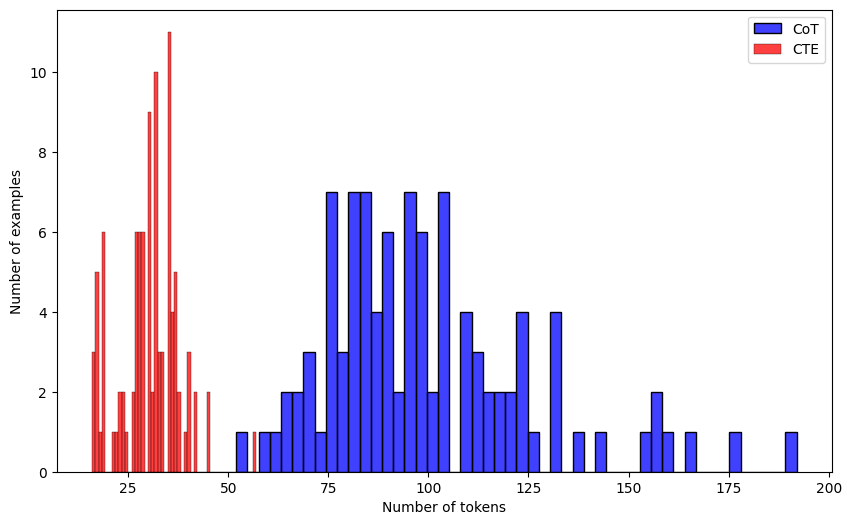

In [41]:
# plot distribution of number of tokens for each dataframe
# in same plot
import matplotlib.pyplot as plt
import seaborn as sns

# prepare the plot for the paper
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_cot_fs['n_tokens'], bins=50, color='blue', label='CoT')
sns.histplot(df_cte['n_tokens'], bins=50, color='red', label='CTE')
plt.legend()
plt.xlabel('Number of tokens')
plt.ylabel('Number of examples')
plt.savefig('ablation-prompt-efficiency.png', dpi=300)


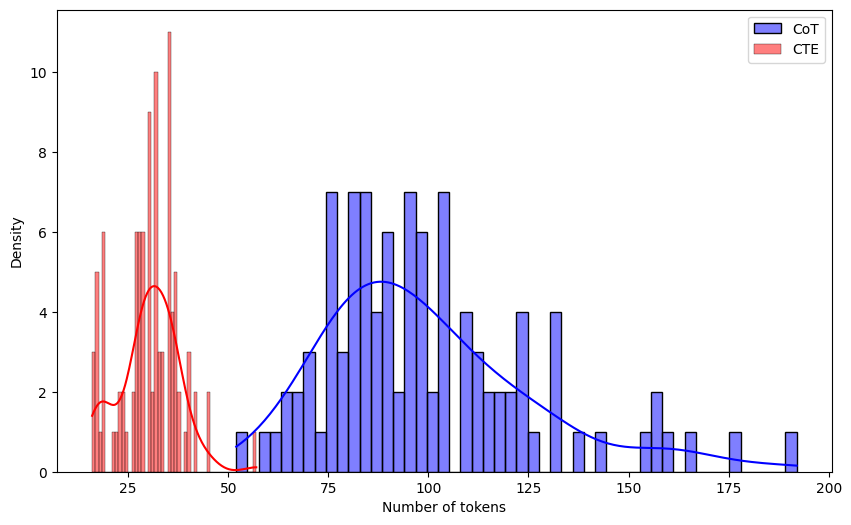

In [42]:
# plot distribution of number of tokens for each dataframe
# in same plot
import matplotlib.pyplot as plt
import seaborn as sns

# prepare the plot for the paper
# do not use bar plot

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(df_cot_fs['n_tokens'], bins=50, color='blue', label='CoT', kde=True)
sns.histplot(df_cte['n_tokens'], bins=50, color='red', label='CTE', kde=True)
plt.legend()
plt.xlabel('Number of tokens')
plt.ylabel('Density')
plt.savefig('ablation-prompt-efficiency-density.png', dpi=300)
k